## PHY688 - Modelling Project
## Author: Paras Sharma (ID#: 115415559)
(Original notebook by Dr. Anowar J. Shajib available [here](https://github.com/ajshajib/lens_modeling_tutorial/blob/main/notebooks/Intro%20to%20lens%20modeling%20with%20lenstronomy.ipynb))

### Modelling a Real Hubble Space Telescope Image (DESIJ0201-2739)

In [1]:
# make sure lenstronomy is installed, otherwise install the latest pip version
try:
    import lenstronomy
except ModuleNotFoundError:
    !pip install lenstronomy

from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots.model_plot import ModelPlot
# from lenstronomy.Util import mask_util, util

In [2]:
# import of standard python libraries
import numpy as np
import corner
import matplotlib.pyplot as plt
import h5py

%matplotlib inline

## Load imaging data

The data and the PSF needs to be provided to `lenstronomy` using the
dictionaries `kwargs_data` and `kwargs_psf`.

In `kwargs_data`, we also need to proivde information on the noise level.
Either the pixel-wise noise map can be provided using the `noise_map`
keyword, or simply the `exposure_time` and `background_rms` can be provided
for `lenstronomy` to create the noise map by itself.

The keywords `ra_at_xy_0` and `dec_at_xy_0` are the RA and Declination in
arcsecond units at the (0, 0) pixel. The keyword `transform_pix2angle` is
the transformation matrix from pixel number coordinates to (RA, Decl.).
These keywords are used to convert pixel coordinates to RA and Decl.
coordinates. If you want to convert one 2D coordinate system to another, you
 will need to the offset between the zeropoints of two coordinate systems
 and transformation matrix that specifies the scaling and rotation of the
 axes. So, the keywords `ra_at_xy_0` and `dec_at_xy_0` specify the zeropoint
  offsets, and `transform_pix2angle` is the tansformation matrix specifying
  scaling and rotation.

In [3]:
with h5py.File("DESIJ0201-2739_F140W.h5", "r") as f:
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]

with h5py.File("psf_F140W.h5", "r") as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]

kwargs_data['noise_map'] = None
kwargs_psf["psf_type"] = "PIXEL"

/var/folders/4r/jq9w4fy92y9_bqzvdfk2d5h40000gn/T/ipykernel_23055/652338674.py:2: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(kwargs_data['image_data']), origin="lower", cmap="cubehelix");


Text(0.5, 1.0, 'DESIJ0201-2739 (F140W)')

<Figure size 640x480 with 0 Axes>

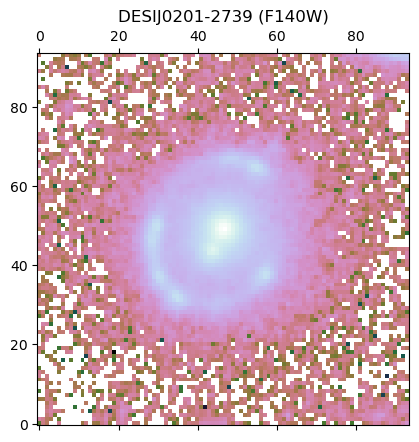

In [4]:
plt.figure()
plt.matshow(np.log10(kwargs_data['image_data']), origin="lower", cmap="cubehelix");
plt.title("DESIJ0201-2739 (F140W)")

## Masking the data

/var/folders/4r/jq9w4fy92y9_bqzvdfk2d5h40000gn/T/ipykernel_23055/637607323.py:8: RuntimeWarning: divide by zero encountered in log10
  plt.matshow(np.log10(kwargs_data['image_data']*circle_mask), origin="lower", cmap="cubehelix");
/var/folders/4r/jq9w4fy92y9_bqzvdfk2d5h40000gn/T/ipykernel_23055/637607323.py:8: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(kwargs_data['image_data']*circle_mask), origin="lower", cmap="cubehelix");


Text(0.5, 1.0, 'DESIJ0201-2739 (F140W) + MASK')

<Figure size 640x480 with 0 Axes>

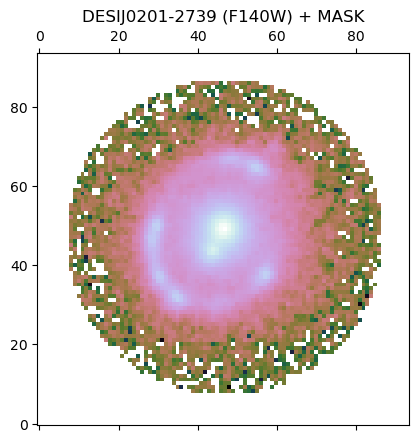

In [5]:
circle_mask = np.zeros_like(kwargs_data['image_data'])
y, x = np.mgrid[:circle_mask.shape[0], :circle_mask.shape[1]]
r = np.sqrt((x-kwargs_data['image_data'].shape[1]/2)**2 + (y-kwargs_data['image_data'].shape[0]/2)**2)
circle_mask[r < 40] = 1
# kwargs_data['image_data'] = kwargs_data['image_data'] * circle_mask

plt.figure()
plt.matshow(np.log10(kwargs_data['image_data']*circle_mask), origin="lower", cmap="cubehelix");
plt.title("DESIJ0201-2739 (F140W) + MASK")
# plt.scatter([47], [47], color="red", marker="x")

## Building a lens model

Here, we build a lens model. The lens model can be thought of three
components: the lens galaxy's mass model, the lens galaxy's light model, and
the source galaxy's light model. We have to give a list of profiles for each
 component as shown in the next codecell.

The `'EPL'` lens mass profile stands for Elliptical Power Law. The form of
this convergence profile is given by:
$$\kappa(x, y) = \frac{3 - \gamma}{2} \left[ \frac{\theta_{\rm E}}{\sqrt{q
x^2 + y^2 / q}} \right]^{\gamma - 1}. $$

The position angle $\phi$ adjusts the orientation of the mass profile's
major axis. The ellipticity parameters $q$ and $\phi$ can be reformulated as
$$e_1 = \frac{1 - q}{1 + q} \cos 2\phi,$$
$$e_2 = \frac{1 - q}{1 + q} \sin 2\phi.$$

`lenstronomy` uses $e_1$ and $e_2$ instead of $q$ and $\phi$, because $e_1$
and $e_2$ are easier to handle in numerical optimization, for example, in
MCMC. You can check [here](https://github.com/lenstronomy/lenstronomy-tutorials/blob/main/Notebooks/GettingStarted/units_coordinates_parameters_definitions.ipynb) for more details on
parameter definitions and conventions used in `lenstronomy`.


Both the lens galaxy's and the source galaxy's light profiles are modeled
with Sersic function, which is given by:

$$I(x, y) = I_{\rm e} \exp \left[ -b_{n} \left\{ \left( \frac{\sqrt{q x^2
+ y^2/q}}{R_{\rm Sersic}} \right)^{1/n_{\rm Sersic}} - 1 \right\}
\right].$$

In [6]:
lens_model_list = ["EPL", "SHEAR"]
source_model_list = ["SERSIC_ELLIPSE", "SHAPELETS"]
lens_light_model_list = ["SERSIC_ELLIPSE"]

In this cell below, we have to specify the initial values, upper and lower
limits for the model parameters specific to each of the model components
specified in the above lists. The `kwargs_*_sigma` dictionaries/lists are
used to set the initial size of the search area within particle swarm
optimization (PSO) or MCMC.

In [14]:
# lens galaxy's mass model
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({})
kwargs_lens_init.append(
    {
        "theta_E": 1.0,
        "gamma": 2.0,
        "e1": 0.0,
        "e2": 0.0,
        "center_x": 0.0,
        "center_y": 0.0,
    }
)
kwargs_lens_sigma.append(
    {
        "theta_E": 0.2,
        "gamma": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.5,
        "center_y": 0.5,
    }
)
kwargs_lower_lens.append(
    {
        "theta_E": 0.01,
        "gamma": 1.0,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -10,
        "center_y": -10,
    }
)
kwargs_upper_lens.append(
    {
        "theta_E": 10.0,
        "gamma": 3.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 10,
        "center_y": 10,
    }
)
fixed_lens.append({'ra_0': 0, 'dec_0': 0})
kwargs_lens_init.append({'gamma1': 0., 'gamma2': 0.0})
kwargs_lens_sigma.append({'gamma1': 0.1, 'gamma2': 0.1})
kwargs_lower_lens.append({'gamma1': -0.3, 'gamma2': -0.3})
kwargs_upper_lens.append({'gamma1': 0.3, 'gamma2': 0.3})


lens_params = [
    kwargs_lens_init,
    kwargs_lens_sigma,
    fixed_lens,
    kwargs_lower_lens,
    kwargs_upper_lens,
]


# lens galaxy's light model
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

# - Sersic 1
fixed_lens_light.append({"n_sersic": 4.0})
kwargs_lens_light_init.append(
    {
        "R_sersic": 0.5,
        "n_sersic": 2,
        "e1": 0,
        "e2": 0,
        "center_x": 0.0,
        "center_y": 0,
        "amp": 16,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)


joint_lens_with_light = [[0, 0, ["center_x", "center_y", "e1", "e2"]]] 
joint_two_sources = [[0, 1, ["center_x", "center_y"]]]

lens_light_params = [
    kwargs_lens_light_init,
    kwargs_lens_light_sigma,
    fixed_lens_light,
    kwargs_lower_lens_light,
    kwargs_upper_lens_light,
]


# source galaxy's light model
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({"n_sersic": 1.0})
kwargs_source_init.append(
    {
        "R_sersic": 0.2,
        "n_sersic": 1,
        "e1": 0,
        "e2": 0,
        "center_x": 0.0,
        "center_y": 0,
        "amp": 16,
    }
)
kwargs_source_sigma.append(
    {
        "n_sersic": 0.5,
        "R_sersic": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.2,
        "center_y": 0.2,
        "amp": 10,
    }
)
kwargs_lower_source.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_source.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)
fixed_source.append({"n_max": 10})
kwargs_source_init.append({"center_x": 0, "center_y": 0, "beta": 0.1})
# kwargs_source_init.append({"center_x": 0.2227, "center_y": 0.1119, "beta": 0.1074})
kwargs_source_sigma.append({"center_x": 0.2, "center_y": 0.2, "beta": 0.001})
kwargs_lower_source.append({"center_x": -10, "center_y": -10, "beta": 0.001})
kwargs_upper_source.append({"center_x": 10, "center_y": 10, "beta": 0.18})


source_params = [
    kwargs_source_init,
    kwargs_source_sigma,
    fixed_source,
    kwargs_lower_source,
    kwargs_upper_source,
]


# combining all the above specification in the `kwargs_params` dictionary
kwargs_params = {
    "lens_model": lens_params,
    "source_model": source_params,
    "lens_light_model": lens_light_params,
}

kwargs_constraints = {"joint_lens_with_light": joint_lens_with_light,
                      "joint_source_with_source": joint_two_sources,
                      }

#### Numerical settings

No need to change anything here for now. It's also fine to not
understand these settings for now.

In [15]:
kwargs_likelihood = {"check_bounds": True, 
                     "image_likelihood_mask_list": [circle_mask]}

kwargs_numerics = {"supersampling_factor": 1, "supersampling_convolution": False}

#### Combining all the information to be sent to lenstronomy

In [16]:
kwargs_model = {
    "lens_model_list": lens_model_list,
    "source_light_model_list": source_model_list,
    "lens_light_model_list": lens_light_model_list,
}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {
    "multi_band_list": multi_band_list,
    "multi_band_type": "single-band"
}

## Here the model fiting is done

In [17]:
fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)

fitting_kwargs_list = [
    ["PSO", {"sigma_scale": 1.0, "n_particles": 200, "n_iterations": 100}],
    # ['MCMC', {'n_burn': 200, 'n_run': 600, 'n_walkers':
    # 200, 'sigma_scale': .1}]
]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...


100%|██████████| 100/100 [18:07<00:00, 10.88s/it]

Max iteration reached! Stopping.
-4.3939206033200895 reduced X^2 of best position
-10831.014287184022 log likelihood
4930 effective number of data points
[{'theta_E': 1.3795247941504158, 'gamma': 1.6881059763260295, 'e1': -0.12691290305293576, 'e2': -0.17656353960827867, 'center_x': 0.07521691324200311, 'center_y': 0.08630447205044722}, {'gamma1': -0.14486484768826968, 'gamma2': -0.10606705080811364, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.11127682554900191, 'n_sersic': 1.0, 'e1': 0.05449780494347624, 'e2': 0.1435603307957782, 'center_x': 0.11168244842712712, 'center_y': 0.09774772294625488}, {'amp': 1, 'n_max': 10, 'beta': 0.05066316715517248, 'center_x': 0.11168244842712712, 'center_y': 0.09774772294625488}] source result
[{'amp': 1, 'R_sersic': 0.5869861100075086, 'n_sersic': 4.0, 'e1': -0.12691290305293576, 'e2': -0.17656353960827867, 'center_x': 0.07521691324200311, 'center_y': 0.08630447205044722}] lens light result
[] point source result
[] tracer source re

## Visualizing the fitted model

-3.851892690927722 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  3.851892690928091


/Users/paras/Library/CloudStorage/GoogleDrive-paras.sharma@stonybrook.edu/My Drive/SBU Courses/Spring 2025/PHY688 - Lensing/coding/lenstronomy/lenstronomy/Plots/model_band_plot.py:160: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),
/var/folders/4r/jq9w4fy92y9_bqzvdfk2d5h40000gn/T/ipykernel_23055/565317093.py:17: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


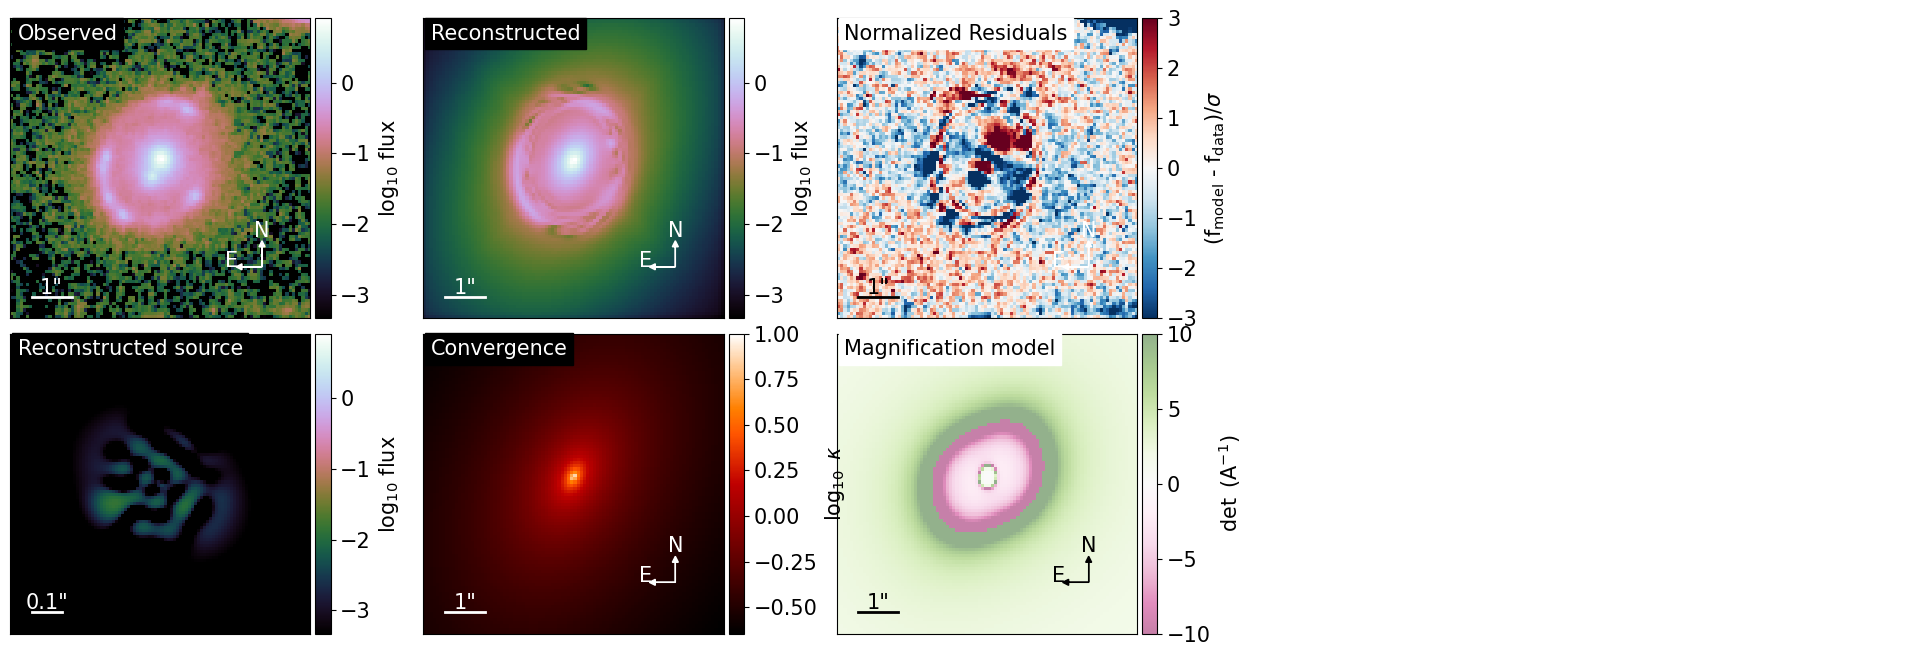

/Users/paras/Library/CloudStorage/GoogleDrive-paras.sharma@stonybrook.edu/My Drive/SBU Courses/Spring 2025/PHY688 - Lensing/coding/lenstronomy/lenstronomy/Plots/model_band_plot.py:1111: RuntimeWarning: invalid value encountered in log10
  np.log10(model),


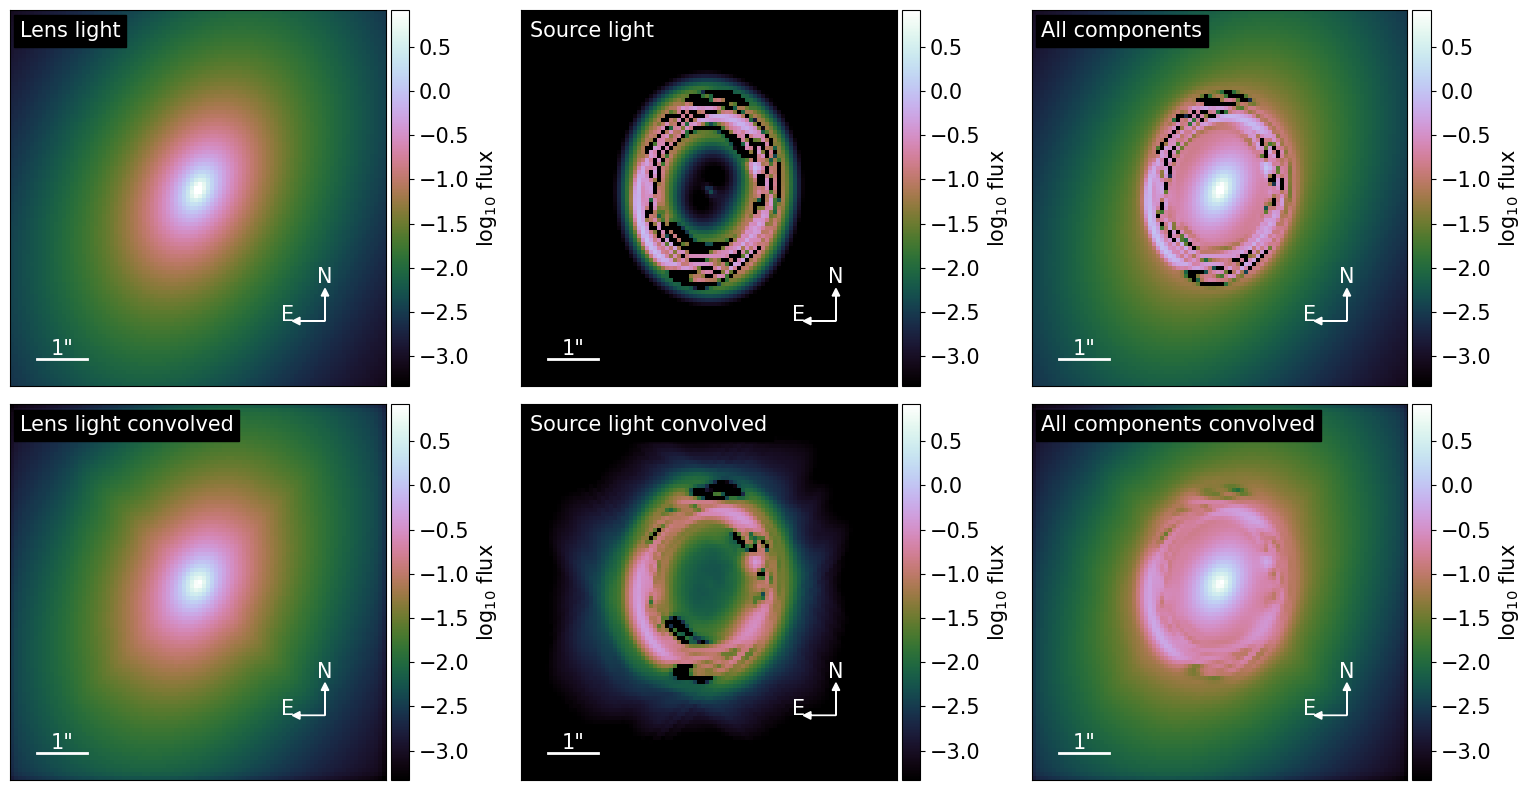

{'kwargs_lens': [{'theta_E': 1.3795247941504158, 'gamma': 1.6881059763260295, 'e1': -0.12691290305293576, 'e2': -0.17656353960827867, 'center_x': 0.07521691324200311, 'center_y': 0.08630447205044722}, {'gamma1': -0.14486484768826968, 'gamma2': -0.10606705080811364, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 56.95968989922776, 'R_sersic': 0.11127682554900191, 'n_sersic': 1.0, 'e1': 0.05449780494347624, 'e2': 0.1435603307957782, 'center_x': 0.11168244842712712, 'center_y': 0.09774772294625488}, {'amp': array([-4.10215006e+02, -2.97310038e+00, -3.57626808e+00, -4.88804022e+01,
       -4.06140415e+01, -2.68684283e+01, -7.75983200e+00, -5.13371911e+01,
        7.47548200e-01, -4.35067422e+00, -4.35324215e+01, -1.49686366e+01,
       -3.98897246e+01,  5.11781669e+01, -7.76176252e+01,  3.16669713e+01,
       -4.35677379e+01,  2.85972568e+01, -1.33525203e+00,  7.99180515e+00,
       -2.40029269e+01,  5.19581887e+00, -6.82882258e+01,  1.23286692e+01,
       -2.68593073e+01, -2.04207804e

In [18]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()
print(kwargs_result)

#### visualizing the MCMC chain, if run

In [15]:
if len(chain_list) > 1:
    sampler_type, samples_mcmc, param_mcmc, dist_mcmc = chain_list[1]

    param_class = fitting_seq.param_class

    print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
    print("parameters in order: ", param_mcmc)
    print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])
    n_sample = len(samples_mcmc)
    print(n_sample)
    samples_mcmc_cut = samples_mcmc[int(n_sample * 1 / 2.0) :]
    if not samples_mcmc == []:
        n, num_param = np.shape(samples_mcmc_cut)
        plot = corner.corner(
            samples_mcmc_cut[:, :], labels=param_mcmc[:], show_titles=True
        )

## Discussion: My Model compared to Rafee et al. (2024) [Old]

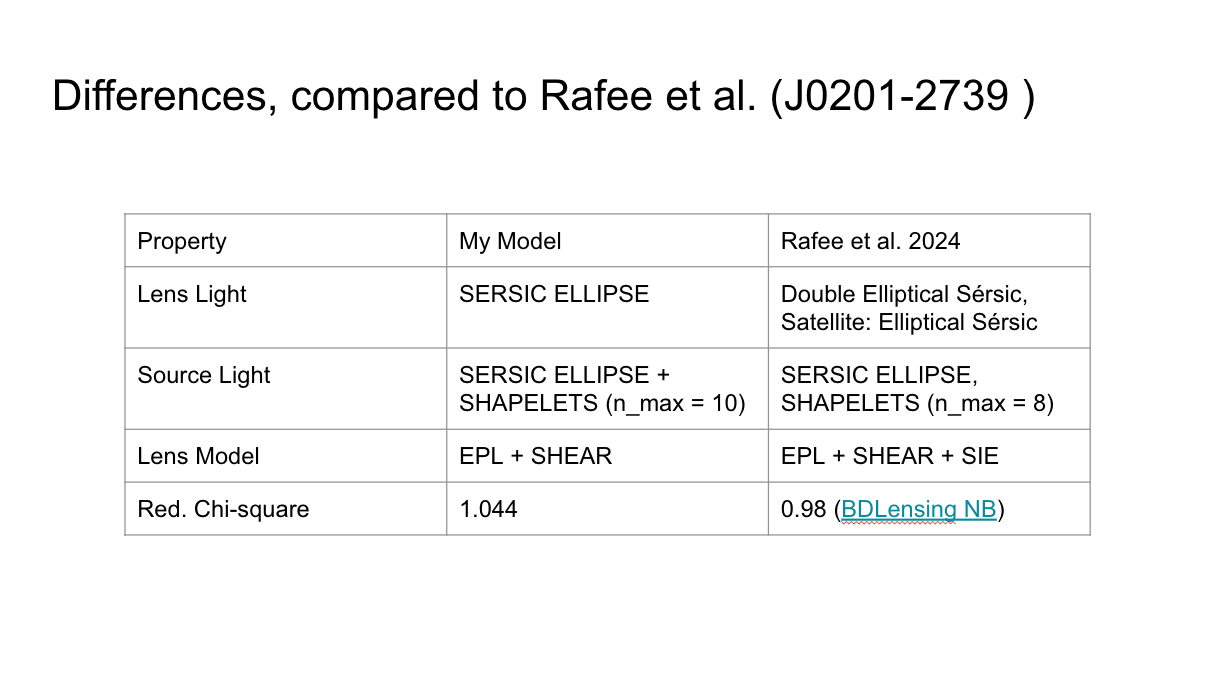

https://github.com/AstroBridge/BDLensing/blob/main/analysis/make_lens_model_figure.ipynb

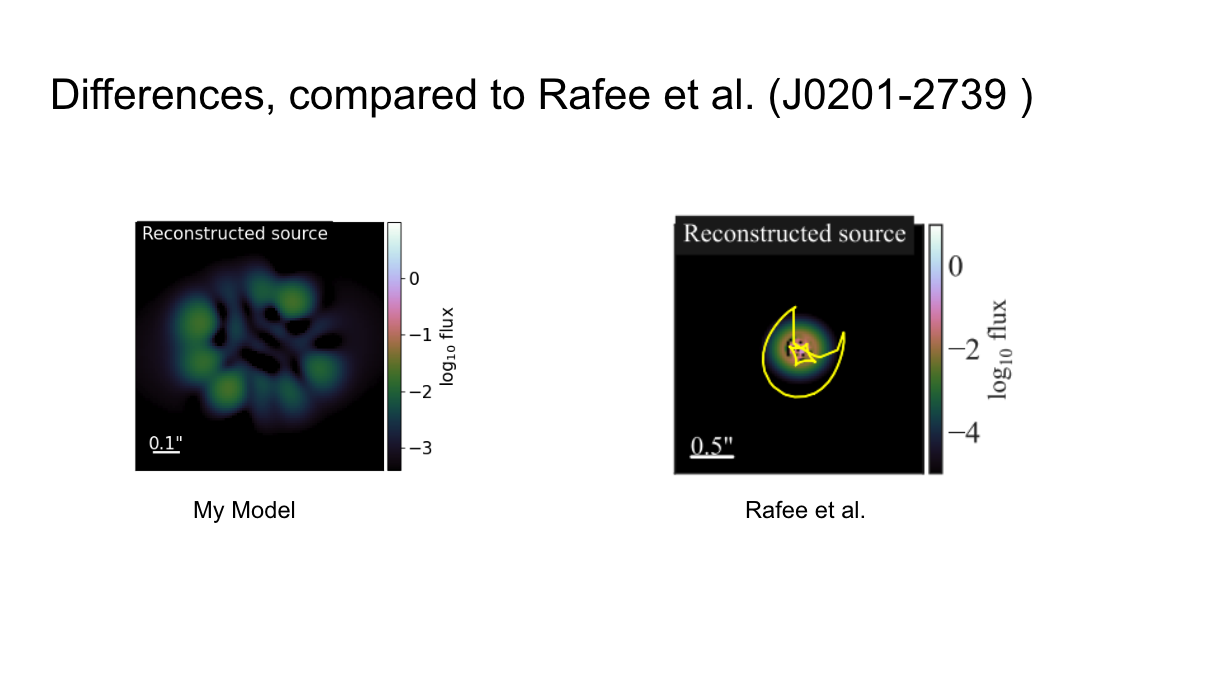

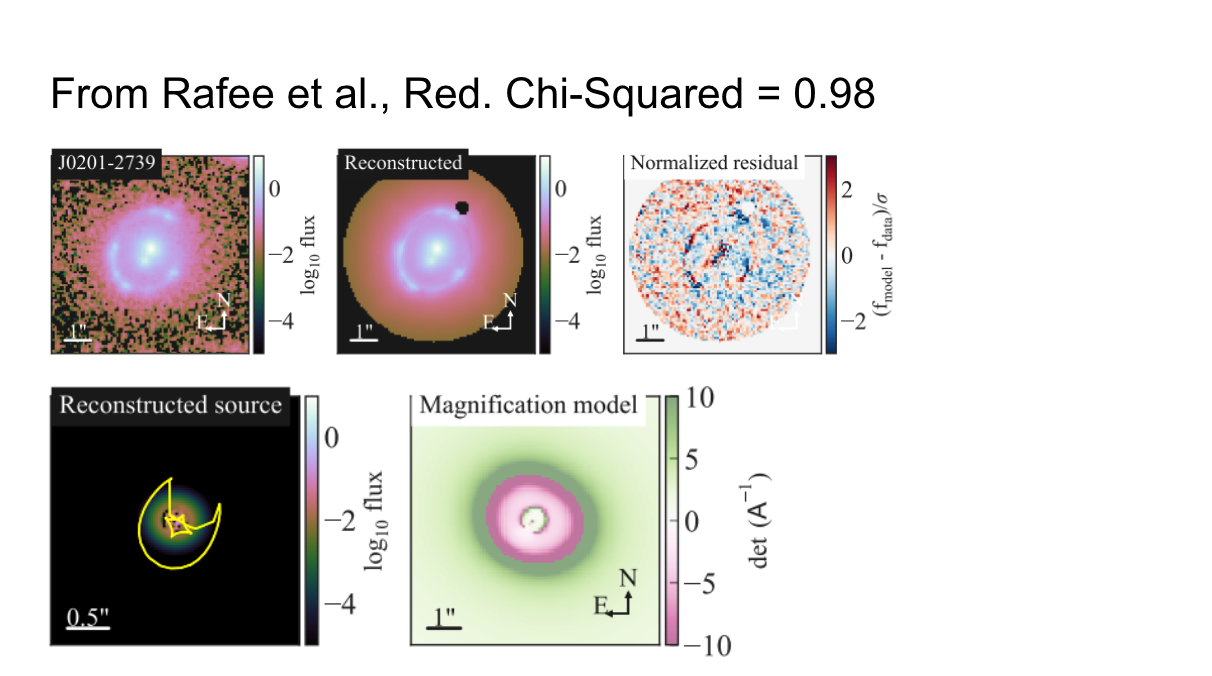

My model certainly uses less number of parameters than Rafee et al. (2024) and so it produces a different source light profile. However the reduced chi-square is almost ~1, which is a good indication that the model is a good fit to the data. But again there can be multiple models that can fit the data well to produce a reduced chi-square of ~1.

My model didn't consider the SIE profile for the lens in addition to the EPL and SHEAR, but Rafee et al. (2024) did. Additionally my model only considered a broad source distribution earlier which also caused the source light profile to be different.